In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
import keras
from keras import layers, Model, callbacks, activations, optimizers, metrics, losses, regularizers

2025-01-12 00:22:28.353219: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 00:22:28.369381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 00:22:28.385558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 00:22:28.390366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 00:22:28.403877: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.__version__

'2.17.0'

In [3]:
keras.__version__

'3.4.1'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# keras.mixed_precision.set_global_policy('mixed_float16')

In [6]:
class CustomArgs:
    def __init__(self):
        self.seed = 2025
        self.bs = 4096
        self.lr = 1e-3
        # self.weight_decay = 1e-4
        self.dropouts = [0.2, 0.2, 0.3, 0.3, 0.3]
        self.n_hidden = [384, 896, 896, 394]
        self.patience = 15
        self.max_epochs = 100
        self.N_fold = 5

# class CustomArgs:
#     def __init__(self):
#         self.seed = 2025
#         self.bs = 4096
#         self.lr = 1e-3
#         self.weight_decay = 5e-4
#         self.dropouts = [0.3, 0.3, 0.3, 0.3, 0.2]
#         self.n_hidden = [512, 256, 128, 128]
#         self.patience = 10
#         self.max_epochs = 100
#         self.N_fold = 5

# class CustomArgs:
#     def __init__(self):
#         self.seed = 2025
#         self.bs = 4096
#         self.lr = 1e-3
#         # self.weight_decay = 1e-4
#         self.dropouts = [0.10431484318345882, 0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
#         self.n_hidden = [896, 448, 448, 256]
#         self.patience = 15
#         self.max_epochs = 100
#         self.N_fold = 5

# Load and prepare data
args = CustomArgs()
tf.random.set_seed(args.seed)

In [7]:
# produced by claude, only keep 22, 28, 27, 25, 26
# drop_features = [21, 23, 24, 29, 30, 31]
# feature_names = [f"feature_{i:02d}" for i in range(79) if i not in [9, 10, 11, 61] + drop_features]
# feature_names = [f"feature_{i:02d}" for i in range(79)]

# catboost selected features
selected = [6, 7, 0, 2, 60, 24, 4, 59, 5, 8, 1, 36, 38, 58, 22, 30, 15, 23, 20, 56, 29, 26, 25, 47, 48, 31, 27, 68]
feature_names = [f"feature_{i:02d}" for i in selected]
# lag_cols = [f"responder_{idx}_lag_1" for idx in range(9)]
lag_cols = [f"responder_{idx}_lag_1" for idx in [3, 6, 7, 8]]
time_cols = ['sin_time_id', 'cos_time_id','sin_time_id_half_day','cos_time_id_half_day']
cat_features = ['feature_09_cat_0', 'feature_09_cat_1', 'feature_09_cat_2', 'feature_09_cat_3', 'feature_09_cat_4', 
 'feature_09_cat_5', 'feature_09_cat_6', 'feature_09_cat_7', 'feature_09_cat_8', 'feature_09_cat_9', 
 'feature_09_cat_10', 'feature_10_cat_0', 'feature_10_cat_1', 'feature_10_cat_2', 'feature_10_cat_3', 
 'feature_10_cat_4', 'feature_10_cat_5', 'feature_10_cat_6', 'feature_10_cat_7', 'feature_10_cat_8', 
 'feature_11_cat_0', 'feature_11_cat_1']
# categorical_cols = ["feature_09", "feature_10", "feature_11"]
label_name = 'responder_6'
weight_name = 'weight'

## Load Data

In [8]:
# Load data
train = pl.scan_parquet("/root/autodl-tmp/jane-street-2024/train-validate-set/train_fold_2.parquet").collect().to_pandas()
valid = pl.scan_parquet("/root/autodl-tmp/jane-street-2024/train-validate-set/valid_fold_2.parquet").collect().to_pandas()
train.shape, valid.shape
# train = pd.concat([train, valid]).reset_index(drop=True)

((30370711, 126), (3593216, 126))

## Feature engineering

In [9]:
train = train[["date_id", "symbol_id"] + feature_names + lag_cols + time_cols + cat_features + [label_name] + [weight_name]]
valid = valid[["date_id", "symbol_id"] + feature_names + lag_cols + time_cols + cat_features + [label_name] + [weight_name]]

In [10]:
# Fill missing values
train[feature_names + lag_cols] = train[feature_names + lag_cols].ffill().fillna(0)
valid[feature_names + lag_cols] = valid[feature_names + lag_cols].ffill().fillna(0)

In [11]:
train[cat_features] = train[cat_features].astype(int)
valid[cat_features] = valid[cat_features].astype(int)

In [12]:
def add_rolling_stat(df: pd.DataFrame):
    """Add rolling statistics with optimized performance"""
    
    # Pre-allocate all new columns in a dictionary
    new_columns = {}
    
    # Process features in groups to avoid fragmentation
    for feat in feature_names:
        # Group calculations for each feature
        grouped = df.groupby("date_id")[feat]
        
        # Calculate all statistics at once
        new_columns.update({
            f"{feat}_ema_5": grouped.ewm(span=1000).mean().reset_index(0, drop=True)
        })
    
    # Create new dataframe with all new columns
    new_df = pd.DataFrame(new_columns)
    
    # Concatenate with original dataframe efficiently
    result = pd.concat([df, new_df], axis=1)
    
    return result

In [13]:
# train = add_rolling_stat(train)
# valid = add_rolling_stat(valid)
# train.shape

In [14]:
# # standard scaler
# means = train[feature_names].mean()
# stds = train[feature_names].std()

# train[feature_names] = (train[feature_names] - means) / stds
# valid[feature_names] = (valid[feature_names] - means) / stds

In [15]:
train.head()

,date_id,symbol_id,feature_06,feature_07,feature_00,feature_02,feature_60,feature_24,feature_04,feature_59,...,feature_10_cat_3,feature_10_cat_4,feature_10_cat_5,feature_10_cat_6,feature_10_cat_7,feature_10_cat_8,feature_11_cat_0,feature_11_cat_1,responder_6,weight
0,399,0,-2.237359,1.097173,-0.453808,-1.123646,3.781964,2.047261,-3.384918,7.715572,...,0,0,0,1,0,0,1,0,1.352247,1.752883
1,399,1,-2.782829,1.819493,-0.438661,-0.700854,3.702588,1.125364,-3.447633,6.492496,...,0,0,0,1,0,0,1,0,-1.987774,2.768091
2,399,2,-4.270811,1.777802,-0.396425,-0.506801,5.091932,0.808474,-2.614925,8.028045,...,0,0,0,0,0,0,1,0,-5.000000,1.366166
3,399,3,-3.133297,1.943953,-0.764966,-0.342314,3.326953,1.279059,-3.321225,9.216970,...,0,0,0,0,0,0,1,0,3.309647,0.929881
4,399,7,-1.925597,2.595224,-0.671893,-0.476501,8.399661,0.964512,-2.565749,23.756943,...,0,0,0,1,0,0,1,0,1.125397,1.582554


In [16]:
train.columns

Index(['date_id', 'symbol_id', 'feature_06', 'feature_07', 'feature_00',
       'feature_02', 'feature_60', 'feature_24', 'feature_04', 'feature_59',
       'feature_05', 'feature_08', 'feature_01', 'feature_36', 'feature_38',
       'feature_58', 'feature_22', 'feature_30', 'feature_15', 'feature_23',
       'feature_20', 'feature_56', 'feature_29', 'feature_26', 'feature_25',
       'feature_47', 'feature_48', 'feature_31', 'feature_27', 'feature_68',
       'responder_3_lag_1', 'responder_6_lag_1', 'responder_7_lag_1',
       'responder_8_lag_1', 'sin_time_id', 'cos_time_id',
       'sin_time_id_half_day', 'cos_time_id_half_day', 'feature_09_cat_0',
       'feature_09_cat_1', 'feature_09_cat_2', 'feature_09_cat_3',
       'feature_09_cat_4', 'feature_09_cat_5', 'feature_09_cat_6',
       'feature_09_cat_7', 'feature_09_cat_8', 'feature_09_cat_9',
       'feature_09_cat_10', 'feature_10_cat_0', 'feature_10_cat_1',
       'feature_10_cat_2', 'feature_10_cat_3', 'feature_10_cat_4',
   

## Data formatting

In [17]:
class CustomDataGenerator(keras.utils.PyDataset):
    def __init__(self, df, features, label_name, weight_name, batch_size, shuffle=True, **kwargs):
        # Add super().__init__() call and pass through kwargs
        super().__init__(**kwargs)
        # extract from original datasets
        self.features = df[features].values
        self.labels = df[label_name].values
        self.weights = df[weight_name].values

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.features))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.features) / self.batch_size))
    
    def __getitem__(self, idx):
        # return a complete batch
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.features))
        batch_indexes = self.indexes[start_idx:end_idx]
        
        batch_x = self.features[batch_indexes]
        batch_y = self.labels[batch_indexes]
        batch_w = self.weights[batch_indexes]
        
        return batch_x, batch_y, batch_w
    
    def on_epoch_end(self):
        # shuffle the x
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [18]:
class DataModule:
    def __init__(self, train_df, batch_size, valid_df):
        self.df = train_df
        self.batch_size = batch_size
        self.dates = self.df['date_id'].unique()
        self.valid_df = valid_df
        
    def setup(self, fold=0, N_fold=5):
        # k-fold cv for training 5 nns and see the performance
        selected_dates = [date for ii, date in enumerate(self.dates) if ii % N_fold != fold]
        df_train = self.df.loc[self.df['date_id'].isin(selected_dates)]
        
        # get the training set
        self.train_generator = CustomDataGenerator(
            df_train,                    # train in this fold
            feature_names + lag_cols + cat_features,    # get rid of time columns
            label_name, 
            weight_name, 
            self.batch_size, 
            shuffle=True,
            workers=12,                  # 15 max
            use_multiprocessing=True,
        )

        # get the valid set
        self.val_generator = CustomDataGenerator(
            self.valid_df,              # always use the same valid set
            feature_names + lag_cols + cat_features,
            label_name,
            weight_name,
            self.batch_size,
            shuffle=False,
            workers=12,                 # 15 max
            use_multiprocessing=True,
        )

In [19]:
# Initialize data module
data_module = DataModule(train, batch_size=args.bs, valid_df=valid)

## Model training

In [20]:
# batch_size = 4096
# hidden_units = [384, 896, 896, 394]
# dropout_rates = [0.10143786981358652, 0.19720339053599725, 0.2703017847244654, 0.23148340929571917, 0.2357768967777311]
# label_smoothing = 1e-2
# learning_rate = 1e-3

In [21]:
# batch_size = 5000
# hidden_units = [150, 150, 150]
# dropout_rates = [0.2, 0.2, 0.2, 0.2]
# label_smoothing = 1e-2
# learning_rate = 1e-3

In [22]:
def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls = 1e-2, lr = 1e-3):
    
    inp = layers.Input(shape = (num_columns, ))
    x0 = layers.BatchNormalization()(inp)
    
    encoder = layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = layers.Dense(hidden_units[0])(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('swish')(encoder)
    
    decoder = layers.Dropout(dropout_rates[1])(encoder)
    decoder = layers.Dense(num_columns, name = 'decoder')(decoder)

    x_ae = layers.Dense(hidden_units[1])(decoder)
    x_ae = layers.BatchNormalization()(x_ae)
    x_ae = layers.Activation('swish')(x_ae)
    x_ae = layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = layers.Dense(num_labels, activation = 'sigmoid', name = 'ae_action')(x_ae)
    
    x = layers.Concatenate()([x0, encoder])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = layers.Dense(hidden_units[i])(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
        x = layers.Dropout(dropout_rates[i + 2])(x)
        
    out = layers.Dense(num_labels, activation = 'sigmoid', name = 'action')(x)
    
    model = Model(inputs = inp, outputs = [decoder, out_ae, out])
    model.compile(optimizer = optimizers.Adam(learning_rate = lr),
                  loss = {'decoder': losses.MeanSquaredError(), 
                          'ae_action': losses.BinaryCrossentropy(label_smoothing = ls),
                          'action': losses.BinaryCrossentropy(label_smoothing = ls), 
                         },
                  metrics = {'decoder': metrics.MeanAbsoluteError(name = 'MAE'), 
                             'ae_action': metrics.AUC(name = 'AUC'), 
                             'action': metrics.AUC(name = 'AUC'), 
                            }, 
                 )
    
    return model

In [23]:
def create_mlp(num_columns, hidden_units, dropout_rates, learning_rate):
    # define an extra input placeholder that will receive the sample weights
    # sample_weights = layers.Input(shape=(1,))

    inp = layers.Input(shape = (num_columns, ))
    x = layers.BatchNormalization()(inp)
    # x = layers.GaussianNoise(0.03527936123679956)(x) # added
    x = layers.Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)): 
        residual = x
        x = layers.Dense(hidden_units[i], kernel_regularizer=regularizers.l2(1e-3))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activations.swish)(x)
        x = layers.Dropout(dropout_rates[i+1])(x)   

        if hidden_units[i] == hidden_units[i-1]:
            x = layers.Add()([x, residual]) 
        
    out = layers.Dense(1)(x)
    
    model = Model(inputs = inp, outputs = out)
    model.compile(optimizer = optimizers.Adam(learning_rate = learning_rate),
                  loss = losses.MeanSquaredError(), 
                  weighted_metrics = [metrics.R2Score()], 
                 )
    
    return model

In [24]:
# Training loop
for fold in range(args.N_fold):
    print(f"Training fold {fold}")
    
    # Setup data for this fold
    data_module.setup(fold, args.N_fold)
    
    # Create model
    input_dim = data_module.train_generator.features.shape[1]
    model = create_mlp(
        num_columns=input_dim,
        hidden_units=args.n_hidden,
        dropout_rates=args.dropouts,
        learning_rate=args.lr,
        # weight_decay=args.weight_decay
    )
    
    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_r2_score',
        patience=args.patience,
        mode='max',
        restore_best_weights=True
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_r2_score',
        factor=0.5,
        patience=6,
        verbose=1,
        mode='max'
    )
    
    model_checkpoint = callbacks.ModelCheckpoint(
        f'./models/keras_nn_{fold}.keras',
        monitor='val_r2_score',
        save_best_only=True,
        mode='max'
    )
    
    # Train model
    history = model.fit(
        data_module.train_generator,
        validation_data=data_module.val_generator,
        epochs=args.max_epochs,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
    )

    break

Training fold 0


2025-01-12 00:23:39.735297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1026 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:53:00.0, compute capability: 8.6


Epoch 1/100


/root/miniconda3/envs/jane_street/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  self.pid = os.fork()
I0000 00:00:1736612630.040135   60052 service.cc:146] XLA service 0x7fb8fc016190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736612630.040207   60052 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 30

  24/5935 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 5.0713 - r2_score: -1.1927 

I0000 00:00:1736612634.975095   60052 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5935/5935 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 1.9487 - r2_score: -0.0334 - val_loss: 1.9062 - val_r2_score: 0.0058 - learning_rate: 0.0010
Epoch 2/100
5935/5935 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 1.4214 - r2_score: 0.0055 - val_loss: 1.9087 - val_r2_score: 0.0048 - learning_rate: 0.0010
Epoch 3/100
5935/5935 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 1.4193 - r2_score: 0.0063 - val_loss: 1.9022 - val_r2_score: 0.0063 - learning_rate: 0.0010
Epoch 4/100
5935/5935 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 1.4144 - r2_score: 0.0072 - val_loss: 1.9073 - val_r2_score: 0.0014 - learning_rate: 0.0010
Epoch 5/100
5935/5935 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 1.4110 - r2_score: 0.0079 - val_loss: 1.8937 - val_r2_score: 0.0074 - learning_rate: 0.0010
Epoch 6/100
5935/5935 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 1.4096 - r2_score: 0.0081 - val_loss: 1.9370 - val_r2_score: -0.0157 - learning_rate: 0.0010
Epoch 7/100
5935/5935 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 1.4097 - r

In [25]:
# tmp = keras.models.load_model("/root/autodl-tmp/jane-street-2024/nn/models/keras_nn_0.keras")

In [26]:
# preds = tmp.predict(valid[feature_names + lag_cols + cat_features])

## Visualizations

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def plot_training_history(history, fold=None):
    """
    Plot training history with multiple metrics
    """
    # Set style
    # plt.style.use('seaborn')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss Over Time')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper right')
    axes[0].grid(True)
    
    # Plot metrics (R2 Score)
    axes[1].plot(history.history['r2_score'], label='Training R2')
    axes[1].plot(history.history['val_r2_score'], label='Validation R2')
    axes[1].set_title('Model R2 Score Over Time')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('R2 Score')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Add learning rate plot if available
    if 'learning_rate' in history.history:
        ax2 = axes[0].twinx()
        ax2.plot(history.history['learning_rate'], 
                label='Learning Rate', 
                color='g', 
                linestyle='--',
                alpha=0.5)
        ax2.set_ylabel('Learning Rate')
        ax2.legend(loc='upper left')
    
    plt.tight_layout()
    
    # # Save plot if fold is specified
    # if fold is not None:
    #     plt.savefig(f'training_history_fold_{fold}.png')
    
    plt.show()

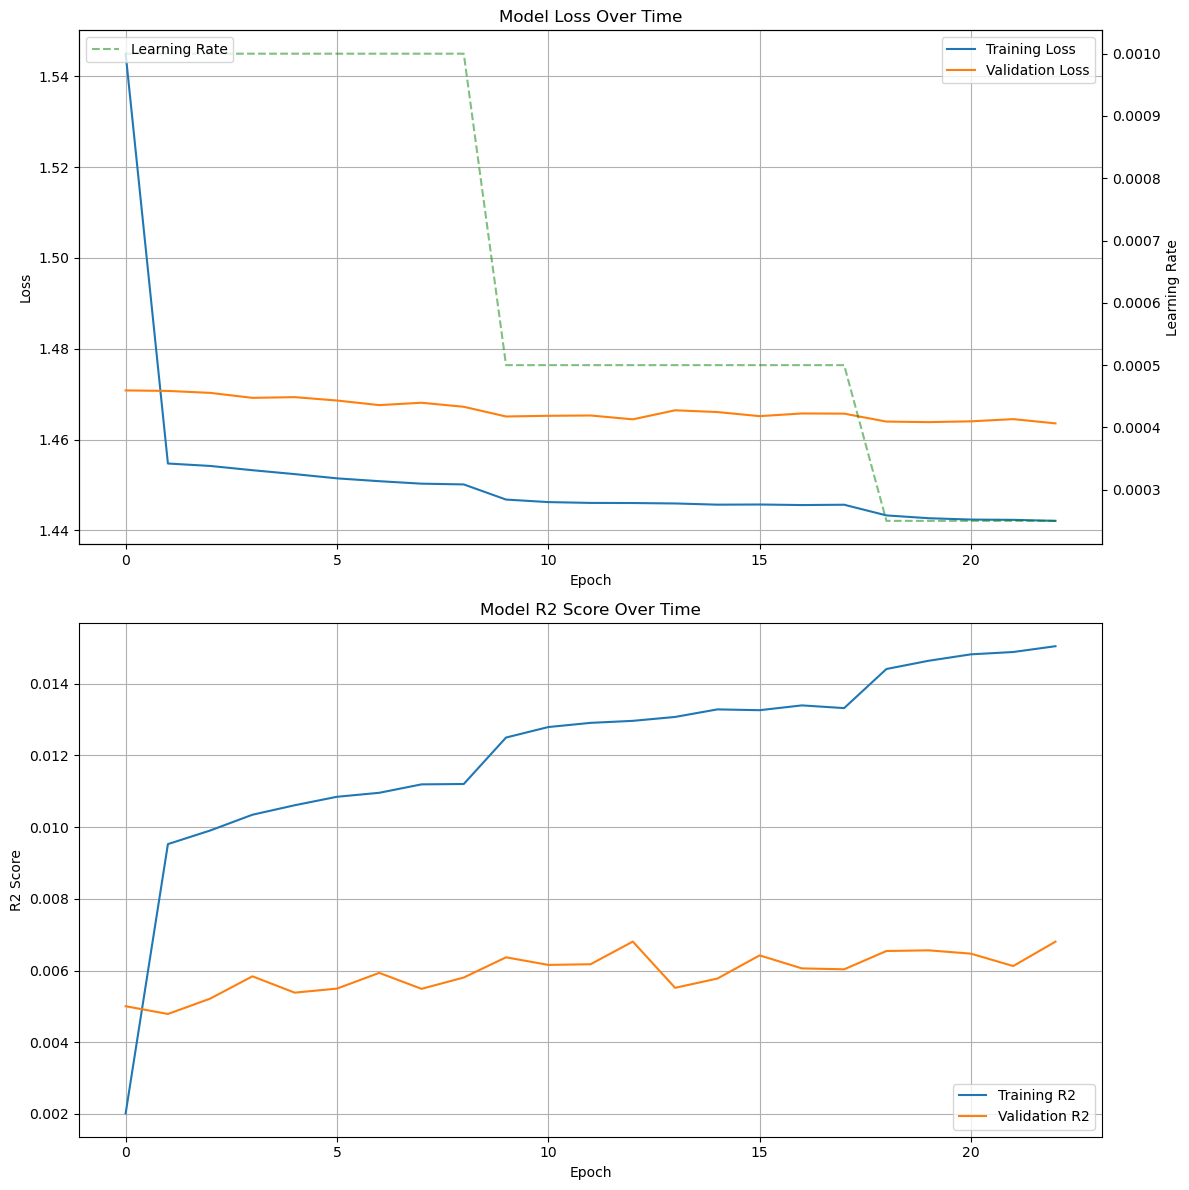

In [23]:
plot_training_history(history)

In [24]:
# Custom R2 metric
# @keras.saving.register_keras_serializable()
# def r2_metric(y_true, y_pred, sample_weight):
#     weighted_mse = tf.reduce_mean(sample_weight * tf.square(y_true - y_pred))
#     weighted_var = tf.reduce_mean(sample_weight * tf.square(y_true)) + 1e-38
#     return 1 - weighted_mse / weighted_var

# @keras.saving.register_keras_serializable()
# def r2_metric(y_true, y_pred):
#     weighted_mse = tf.reduce_mean(tf.square(y_true - y_pred))
#     weighted_var = tf.reduce_mean(tf.square(y_true)) + 1e-38
#     return 1 - weighted_mse / weighted_var

# # Custom R2 metric
# @keras.saving.register_keras_serializable()
# class R2Metric(keras.metrics.Metric):
#     def __init__(self, name='r2', **kwargs):
#         super().__init__(name=name, **kwargs)
#         # Initialize as instance variables
#         self.weighted_mse = self.add_weight(
#             name='weighted_mse',
#             initializer='zeros',
#             shape=()
#         )
#         self.weighted_var = self.add_weight(
#             name='weighted_var',
#             initializer='zeros',
#             shape=()
#         )

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)
        
#         if sample_weight is None:
#             sample_weight = tf.ones_like(y_true)
#         sample_weight = tf.cast(sample_weight, tf.float32)
            
#         # Calculate metrics
#         self.weighted_mse.assign(
#             tf.reduce_mean(sample_weight * tf.square(y_pred - y_true))
#         )
#         self.weighted_var.assign(
#             tf.reduce_mean(sample_weight * tf.square(y_true)) + 1e-38
#         )

#     def result(self):
#         return 1 - self.weighted_mse / self.weighted_var

#     def reset_state(self):
#         self.weighted_mse.assign(0.0)
#         self.weighted_var.assign(0.0)

#     def get_config(self):
#         # Get the base config from the parent class
#         base_config = super().get_config()
#         # Add your custom configurations
#         return {**base_config}
    
#     @classmethod
#     def from_config(cls, config):
#         # The config dict contains all items from get_config
#         return cls(**config)

# @keras.saving.register_keras_serializable()
# class R2Metric(keras.metrics.Metric):
#     def __init__(self, name='r2', **kwargs):
#         super().__init__(name=name, **kwargs)
#         # Track sum of weighted squared errors and total weighted variance
#         self.weighted_sum_squared_error = self.add_weight(
#             name='weighted_sum_squared_error',
#             initializer='zeros',
#             dtype=tf.float32
#         )
#         self.weighted_sum_squared_total = self.add_weight(
#             name='weighted_sum_squared_total',
#             initializer='zeros',
#             dtype=tf.float32
#         )
#         self.sample_weight_sum = self.add_weight(
#             name='sample_weight_sum',
#             initializer='zeros',
#             dtype=tf.float32
#         )

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)
        
#         if sample_weight is None:
#             sample_weight = tf.ones_like(y_true)
#         sample_weight = tf.cast(sample_weight, tf.float32)
        
#         # Accumulate weighted squared errors
#         squared_errors = tf.square(y_true - y_pred)
#         weighted_squared_errors = squared_errors * sample_weight
#         self.weighted_sum_squared_error.assign_add(tf.reduce_mean(weighted_squared_errors))
        
#         # Accumulate weighted squared totals (for variance)
#         squared_totals = tf.square(y_true)
#         weighted_squared_totals = squared_totals * sample_weight
#         self.weighted_sum_squared_total.assign_add(tf.reduce_mean(weighted_squared_totals))
        
#         # Accumulate weights
#         self.sample_weight_sum.assign_add(tf.reduce_mean(sample_weight))

#     def result(self):
#         return 1.0 - (self.weighted_sum_squared_error / (self.weighted_sum_squared_total + 1e-38))

#     def reset_state(self):
#         self.weighted_sum_squared_error.assign(0.0)
#         self.weighted_sum_squared_total.assign(0.0)
#         self.sample_weight_sum.assign(0.0)

#     def get_config(self):
#         # Get the base config from the parent class
#         base_config = super().get_config()
#         # Add your custom configurations
#         return {**base_config}
    
#     @classmethod
#     def from_config(cls, config):
#         # The config dict contains all items from get_config
#         return cls(**config)

# def create_model(input_dim, hidden_dims, dropouts, lr, weight_decay):
#     inputs = layers.Input(shape=(input_dim,))
#     x = inputs
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(dropouts[0])(x)
    
#     for i, hidden_dim in enumerate(hidden_dims):
#         x = layers.Dense(hidden_dim)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation('swish')(x)
#         x = layers.Dropout(dropouts[i])(x)
    
#     x = layers.Dense(1)(x)
#     x = layers.Activation('tanh')(x)
#     outputs = layers.Lambda(lambda x: 5 * x)(x)
    
#     model = Model(inputs=inputs, outputs=outputs)
    
#     # Compile model
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=lr),
#         loss='mse',
#         # change here
#         metrics=['mse']
#     )
    
#     return model